## Step 1 - Explore the Data

The aim if this notebook is to:
* **Read in the intial dataset in its raw form**
* **Begin to understand it's layout and characteristics**
* **Determine opportunities for learning from the patterns it contains**
* **Determine opportunities/needs for data cleansing, etc**

## The Data/Preliminary Questions

The dataset that will be used for this project is titled `beer_reviews.csv` and originates from https://data.world/socialmediadata/beeradvocate

This dataset consists of `1,586,614` observations and has `13` columns as follows:
* `brewery_id`            int64
* `brewery_name`          object
* `review_time`           int64
* `review_overall`        float64
* `review_aroma`          float64
* `review_appearance`     float64
* `review_profilename`    object
* `beer_style`            object
* `review_palate`         float64
* `review_taste`          float64
* `beer_name`             object
* `beer_abv`              float64
* `beer_beerid`           int64

So of these 13 columns, the ones that may be of use to further analysis are, in other words, the features of our data are as follows:
* `review_overall`        float64
* `review_aroma`          float64
* `review_appearance`     float64
* `review_palate`         float64
* `review_taste`          float64

Of course, these features may be of further interest in gaining more knowledge of the domains within which they reside:
* `brewery_id`             int64
* `brewery_name`           object

* `beer_beerid`           int64
* `beer_name`              object

* `beer_style`             object

Finally, we might want to consider the shape (potential legitimacy of the actual review based upon who reviewed (or):
* `review_profilename`    object

It may of particular interest to determine how many reviews a given individual provided as related to reviews other reviewers may have provided.  This could further studied across `beer_style` e.g.,... if a certain reviewer did a fair amount of reviews... but the majority (88%+) were on IPA's... how much value does their review against a Wheat beer really hold.  Likewise... if 90% of their reviews reflect high ratings and they did a good number of reviews, how much value do these high ratings really mean to the actual beers being reviewed




In [1]:
from __future__ import print_function

In [2]:
# setup the essentials
import pandas as pd
import numpy as np

# load the data and take a quick peek
beer_all_data = pd.read_csv("../data/beer_reviews.csv")
beer_all_data.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [3]:
#report the shape and data types found witin
print('shape:\t', beer_all_data.shape)
print('\n')
print('dtpes:\t',beer_all_data.dtypes)

shape:	 (1586614, 13)


dtpes:	 brewery_id              int64
brewery_name           object
review_time             int64
review_overall        float64
review_aroma          float64
review_appearance     float64
review_profilename     object
beer_style             object
review_palate         float64
review_taste          float64
beer_name              object
beer_abv              float64
beer_beerid             int64
dtype: object


In [93]:
# let's explore the variety of beer styles

# store off details by beer style
beer_style_details = beer_all_data.groupby('beer_style').agg({
       'brewery_name': pd.Series.nunique,
       'review_profilename': pd.Series.nunique,
       'beer_name': pd.Series.nunique
    }).rename(columns={
                        'brewery_name' : 'number_of_distinct_brewerys',
                        'review_profilename' : 'number_of_distinct_reviewers',
                        'beer_name' : 'number_of_distinct_beer'                          
                      })

# store off summary by beer styles
beer_style_sum = beer_style_counts.agg({
        'number_of_distinct_brewerys' : ['mean', 'std'],
        'number_of_distinct_reviewers' : ['mean', 'std'],
        'number_of_distinct_beer' : ['mean', 'std']    
    })

# store off high level summary across all beer styles
beer_style_tots = beer_all_data.agg({
       'brewery_name': pd.Series.nunique,
       'review_profilename': pd.Series.nunique,
       'beer_name': pd.Series.nunique
    }).rename(columns={
                        'brewery_name' : 'number_of_distinct_brewerys',
                        'review_profilename' : 'number_of_distinct_reviewers',
                        'beer_name' : 'number_of_distinct_beer'                          
                      })

# some basic conversions for later
#beer_style_sum = pd.DataFrame(beer_style_sum).reset_index()

In [101]:
#-----------------------------------------------------------
# some updates to the detail table from the sum and tots
#-----------------------------------------------------------

#--------- Brewery
beer_style_details['total_brewerys'] = beer_style_tots['brewery_name']
beer_style_details['pct_brewerys'] = beer_style_details['number_of_distinct_brewerys'] / beer_style_details['total_brewerys']
beer_style_details['mean_distinct_brewerys'] = beer_style_sum.loc['mean','number_of_distinct_brewerys']
beer_style_details['sd_distinct_brewerys'] = beer_style_sum.loc['std','number_of_distinct_brewerys']

beer_style_details['Z_distinct_brewerys'] = (
                                                (beer_style_details['number_of_distinct_brewerys'] - beer_style_details['mean_distinct_brewerys'])
                                                    / beer_style_details['sd_distinct_brewerys']
                                                )

#--------- Reviewers
beer_style_details['total_reviewers'] = beer_style_tots['review_profilename']
beer_style_details['pct_reviewers'] = beer_style_details['number_of_distinct_reviewers'] / beer_style_details['total_reviewers']
beer_style_details['mean_distinct_reviewers'] = beer_style_sum.loc['mean','number_of_distinct_reviewers']
beer_style_details['sd_distinct_reviewers'] = beer_style_sum.loc['std','number_of_distinct_reviewers']

beer_style_details['Z_distinct_reviewers'] = (
                                                (beer_style_details['number_of_distinct_reviewers'] - beer_style_details['mean_distinct_reviewers'])
                                                    / beer_style_details['sd_distinct_reviewers']
                                                )

#--------- Beer
beer_style_details['total_beer'] = beer_style_tots['beer_name']
beer_style_details['pct_Beer'] = beer_style_details['number_of_distinct_beer'] / beer_style_details['total_beer']
beer_style_details['mean_distinct_beer'] = beer_style_sum.loc['mean','number_of_distinct_beer']
beer_style_details['sd_distinct_beer'] = beer_style_sum.loc['std','number_of_distinct_beer']

beer_style_details['Z_distinct_beer'] = (
                                                (beer_style_details['number_of_distinct_beer'] - beer_style_details['mean_distinct_beer'])
                                                    / beer_style_details['sd_distinct_beer']
                                                )

beer_style_details.head()


,number_of_distinct_reviewers,number_of_distinct_brewerys,number_of_distinct_beer,total_brewerys,pct_brewerys,mean_distinct_brewerys,sd_distinct_brewerys,Z_distinct_brewerys,total_reviewers,pct_reviewers,mean_distinct_reviewers,sd_distinct_reviewers,Z_distinct_reviewers,total_beer,pct_Beer,mean_distinct_beer,sd_distinct_beer,Z_distinct_beer
beer_style,,,,,,,,,,,,,,,,,,
Altbier,3035,425,465,5742,0.074016,411.259615,346.078418,0.039703,33387,0.090904,3870.201923,2442.428826,-0.341955,56857,0.008178,566.269231,558.586222,-0.181296
American Adjunct Lager,6414,531,1112,5742,0.092476,411.259615,346.078418,0.345992,33387,0.192111,3870.201923,2442.428826,1.041503,56857,0.019558,566.269231,558.586222,0.976986
American Amber / Red Ale,8337,1478,2231,5742,0.257402,411.259615,346.078418,3.082366,33387,0.249708,3870.201923,2442.428826,1.828834,56857,0.039239,566.269231,558.586222,2.980257
American Amber / Red Lager,3924,289,341,5742,0.050331,411.259615,346.078418,-0.353271,33387,0.117531,3870.201923,2442.428826,0.022026,56857,0.005998,566.269231,558.586222,-0.403285
American Barleywine,5560,492,784,5742,0.085684,411.259615,346.078418,0.233301,33387,0.166532,3870.201923,2442.428826,0.691852,56857,0.013789,566.269231,558.586222,0.389789


Brewery dist



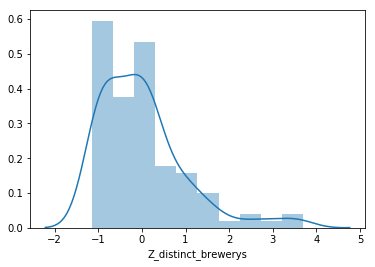

In [107]:
%matplotlib inline
import seaborn as sns

print('Brewery dist\n')
sns.distplot(beer_style_details['Z_distinct_brewerys'])



Reviewer



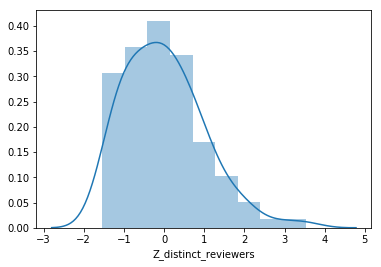

In [108]:
print('\nReviewer\n')
sns.distplot(beer_style_details['Z_distinct_reviewers'])


Beer



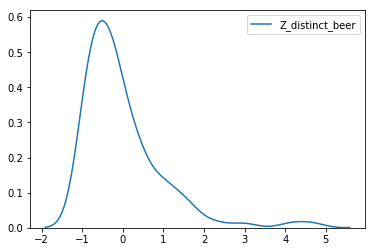

In [111]:
print('\nBeer\n')
sns.distplot(beer_style_details['Z_distinct_beer'])

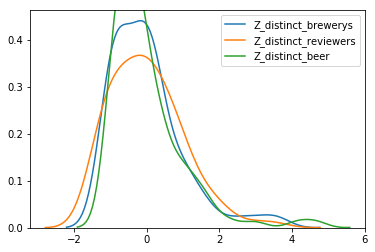

In [113]:
sns.kdeplot(beer_style_details['Z_distinct_brewerys'])
sns.kdeplot(beer_style_details['Z_distinct_reviewers'])
sns.kdeplot(beer_style_details['Z_distinct_beer'])